# Diamonds Data Exploration
## Preliminary Wrangling
This document explores a dataset containing metadata related to loans such as: 
- The type of loan, duration, amount, etc, to
- Customers employment information that would impact there borrowing power i.e. credit rating, job type, etc. <br>
`Additional variables provided in the data dictionary, Prosper Loan Data`

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# for pandasgui dataframe viewer
from pandasgui import show

%matplotlib inline

In [2]:
loans_raw = pd.read_csv('prosperLoanData.csv')

In [3]:
loans_raw.shape

(113937, 81)

In [4]:
loans_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

## Missing Data

In [88]:
# create empty list to hold series data, information is held in .index (column names) and .values (number of Nan per column)
Nan_list_all = []
Nan_list_all = loans_raw.isna().sum()
Nan_list_all

ListingKey                         0
ListingNumber                      0
ListingCreationDate                0
CreditGrade                    84984
Term                               0
                               ...  
PercentFunded                      0
Recommendations                    0
InvestmentFromFriendsCount         0
InvestmentFromFriendsAmount        0
Investors                          0
Length: 81, dtype: int64

In [38]:
# List above contains unnecessary entries limiting viewing.
# Add equality test to narrow down to column names with 
Nan_list = Nan_list_all[Nan_list_all.values > 0]
Nan_list

CreditGrade                             84984
ClosedDate                              58848
BorrowerAPR                                25
EstimatedEffectiveYield                 29084
EstimatedLoss                           29084
EstimatedReturn                         29084
ProsperRating (numeric)                 29084
ProsperRating (Alpha)                   29084
ProsperScore                            29084
BorrowerState                            5515
Occupation                               3588
EmploymentStatus                         2255
EmploymentStatusDuration                 7625
GroupKey                               100596
CreditScoreRangeLower                     591
CreditScoreRangeUpper                     591
FirstRecordedCreditLine                   697
CurrentCreditLines                       7604
OpenCreditLines                          7604
TotalCreditLinespast7years                697
InquiriesLast6Months                      697
TotalInquiries                    

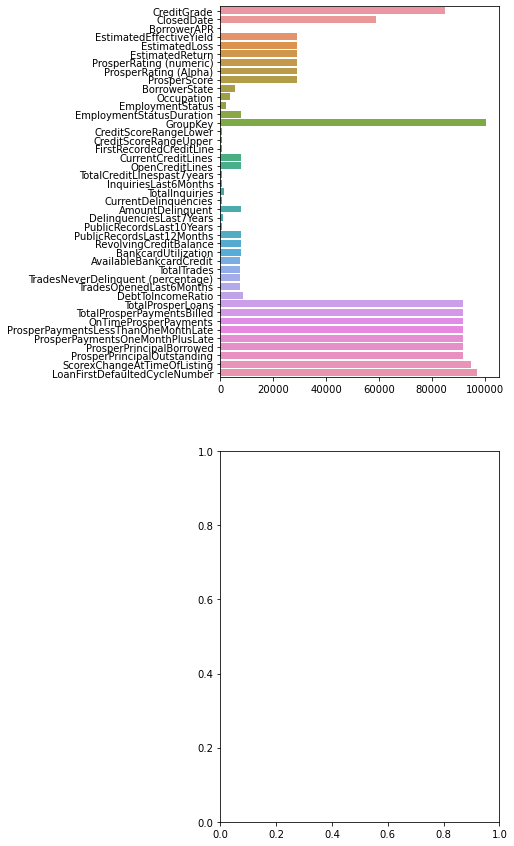

In [96]:
fig, axes = plt.subplots(2,1,figsize=(5,15))
g1=sb.barplot(Nan_list.values, Nan_list.index, ax=axes[0])

# scale transformation
g2=sb.barplot(Nan_list.values, Nan_list.index, ax=axes[1])


plt.show()

## Data dictionary summary:
- CreditGrade/ProsperRating and LoanStatus is an ordinal datatype


In [ ]:
loans_raw.head(5)

In [ ]:
loans_raw.CreditGrade.value_counts(dropna=False)

In [ ]:
loans_raw.CreditGrade.value_counts(dropna=False)

In [ ]:
loans_raw.LoanStatus.value_counts(dropna=False)

In [ ]:
# convert into ordered categorical types per data dictionary
ordinal_var_dict = {'CreditGrade': ['N/A','HR','E','D','C','B','A','AA'],
                    'LoanStatus': ['Cancelled', 'Chargedoff', 'Current', 'Completed', 'FinalPaymentInProgress',                                     'Defaulted', 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due                                         (31-60 days)', 'Past Due (61-90 days)', 'Past Due (91-120 days)', 
                                    'Past Due (>120 days)']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    loans_raw[var] = loans_raw[var].astype(ordered_var)

TypeError: hist() missing 1 required positional argument: 'x'